### Flow data availability

In [86]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import sys
import xarray as xr
import pandas as pd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [28]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')
basins_path = Path(data_path) / cs_basin_folder

# Image output folder
image_path = Path(cs.read_from_config(config_file, 'image_path'))
image_path.mkdir(exist_ok=True, parents=True)

In [4]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [5]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object}) 

### Analysis

In [32]:
# Filter out everything we have marked as unusable
not_these = cs_unusable['Station_id'].unique() # we have some duplicates in here, this removes those
cs_filter = cs_filter[~cs_filter['Station_id'].isin(not_these)]

For how many stations do we have daily and sub-daily data respectively?

In [33]:
no_daily = (cs_filter['flow_obs_missing_daily'] == -1).sum()
no_hourly = (cs_filter['flow_obs_missing_hourly'] == -1).sum()
no_daily_and_hourly = ((cs_filter['flow_obs_missing_daily'] == -1) & (cs_filter['flow_obs_missing_hourly'] == -1)).sum()

print(f'Daily flow observations are missing in {no_daily} basins.')
print(f'Sub-daily flow observations are missing in {no_hourly} basins.')
print(f'Both daily and sub-daily flow observations are missing in {no_daily_and_hourly} basins.')

Daily flow observations are missing in 0 basins.
Sub-daily flow observations are missing in 0 basins.
Both daily and sub-daily flow observations are missing in 0 basins.


How much data is available and how many values are missing?

In [36]:
# Create a dataframe for easier handling
df = cs_filter[['Station_id','Country','iv_flow_obs_availability_start',
           'iv_flow_obs_availability_end','flow_obs_missing_hourly',
           'dv_flow_obs_availability_start','dv_flow_obs_availability_end',
           'flow_obs_missing_daily']].copy()

In [37]:
df['hs'] = pd.to_datetime(df['iv_flow_obs_availability_start']) # Hourly Start
df['he'] = pd.to_datetime(df['iv_flow_obs_availability_end'])   # Hourly End
df['ds'] = pd.to_datetime(df['dv_flow_obs_availability_start']) # Daily Start
df['de'] = pd.to_datetime(df['dv_flow_obs_availability_end'])   # Daily End

In [46]:
df['hd'] = df['he'] - df['hs'] # Hourly Duration
df['dd'] = df['de'] - df['ds'] # Daily Duration

In [54]:
def get_duration_in_hours(value):
    return value.total_seconds() / 3600

def get_duration_in_days(value):
    return value.total_seconds() / (3600*24)

In [80]:
# Round down to hours and days respectively
df['hd'] = df['hd'].apply(lambda x: x.floor('h'))
df['dd'] = df['dd'].apply(lambda x: x.floor('d'))

In [81]:
df['ha'] = df['hd'].apply(get_duration_in_hours) # Hours All
df['da'] = df['dd'].apply(get_duration_in_days) # Days All

In [82]:
df['hm'] = df['flow_obs_missing_hourly'] # Hourly Missing
df['dm'] = df['flow_obs_missing_daily'] # Daily Missing

In [83]:
df['hn'] = df['ha'] - df['hm'] # Hourly Net
df['dn'] = df['da'] - df['dm'] # Daily Net

In [114]:
df['iv_s'] = pd.to_datetime(df['iv_flow_obs_availability_start'])
df['iv_e'] = pd.to_datetime(df['iv_flow_obs_availability_end'])
df['dv_s'] = pd.to_datetime(df['dv_flow_obs_availability_start'])
df['dv_e'] = pd.to_datetime(df['dv_flow_obs_availability_end'])

In [118]:
df['hmp'] = df['hm'] / df['ha'] # Hourly Missing Percentage
df['dmp'] = df['dm'] / df['da'] # Hourly Missing Percentage

In [110]:
df = df.reset_index(drop=True)

### Figures

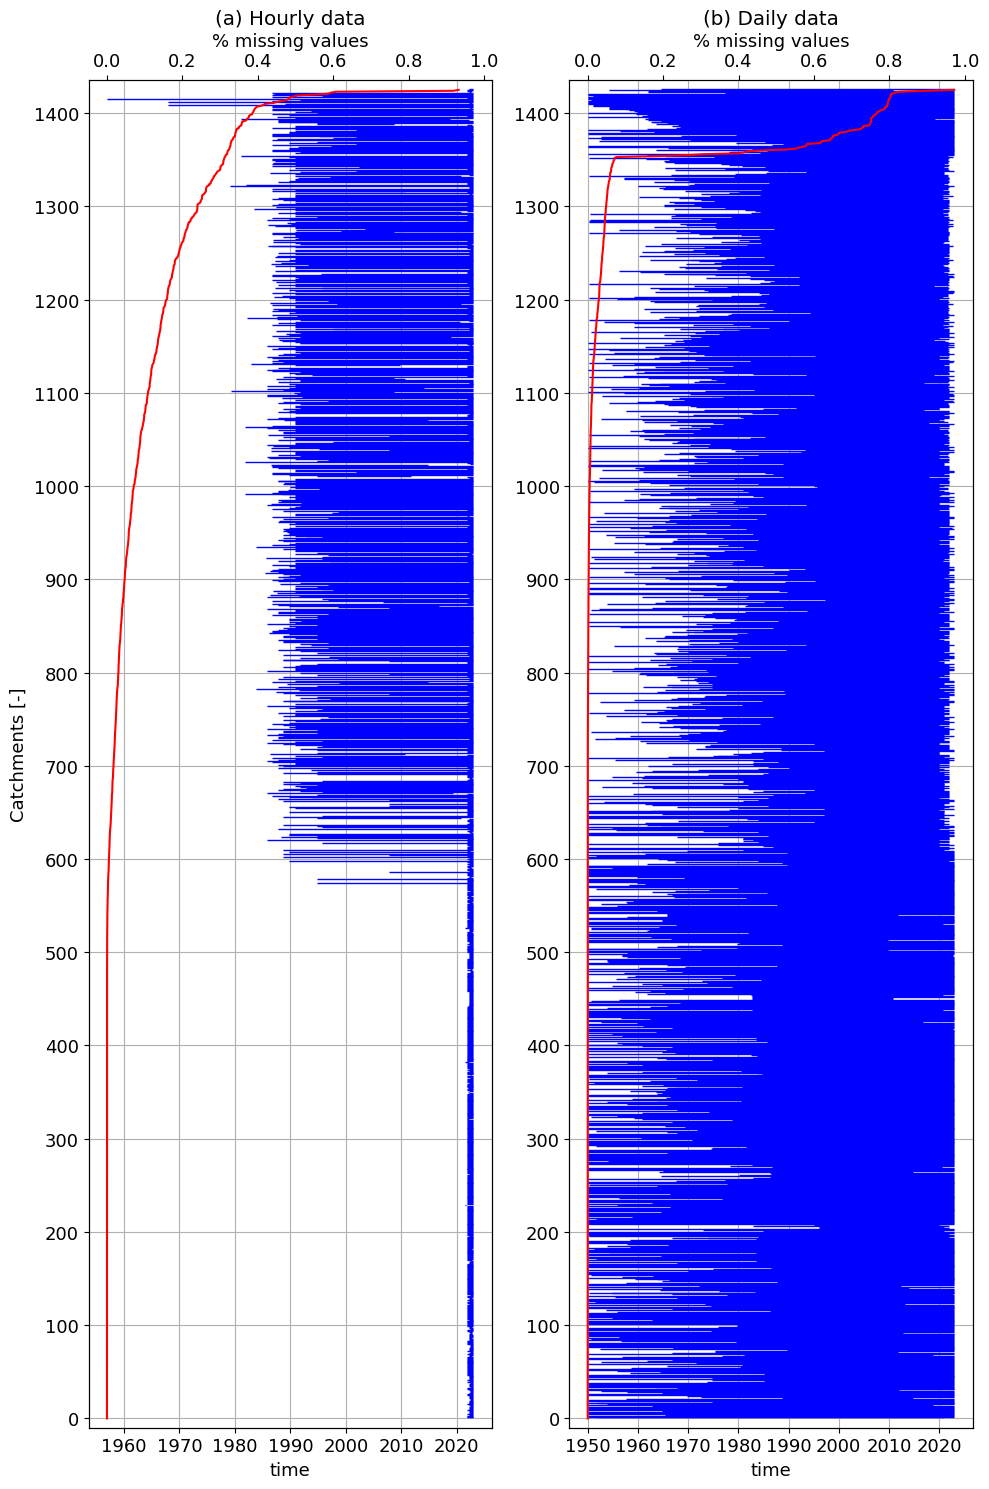

In [209]:
# Create a new figure and axis
fig, axs = plt.subplots(1,2,figsize=(10,15))
fsize=13

ax1 = axs[1]
ax2 = ax1.twiny()
df_plot = df.sort_values(by='dmp').reset_index(drop=True)
# Iterate over each row and plot a horizontal line for the time duration
for index, row in df_plot.iterrows():
    ax1.hlines(index+1, xmin=row['dv_s'], xmax=row['dv_e'], color='blue', linewidth=1)
ax2.plot(df_plot['dmp'], range(0,len(df_plot)), color='red')

# Chart junk
ax1.grid()
ax1.set_xlabel('time', fontsize=fsize)
ax2.set_xlabel('% missing values', fontsize=fsize)
ax1.set_title('(b) Daily data', fontsize=fsize*1.1)
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax1.set_ylim([-10,len(df)+10])
ax1.tick_params(axis='both', which='major', labelsize=fsize)
ax2.tick_params(axis='both', which='major', labelsize=fsize)

ax3 = axs[0]
ax4 = ax3.twiny()
df_plot = df.sort_values(by='hmp').reset_index(drop=True)
# Iterate over each row and plot a horizontal line for the time duration
for index, row in df_plot.iterrows():
    ax3.hlines(index+1, xmin=row['iv_s'], xmax=row['iv_e'], color='blue', linewidth=1)
ax4.plot(df_plot['hmp'], range(0,len(df_plot)), color='red')

# Chart junk
ax3.grid()
ax3.set_xlabel('time', fontsize=fsize)
ax4.set_xlabel('% missing values', fontsize=fsize)
ax3.set_ylabel('Catchments [-]', fontsize=fsize)
ax3.set_title('(a) Hourly data', fontsize=fsize*1.1)
ax3.yaxis.set_major_locator(MultipleLocator(100))
ax4.yaxis.set_major_locator(MultipleLocator(100))
ax3.set_ylim([-10,len(df)+10])
ax4.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', which='major', labelsize=fsize)
ax4.tick_params(axis='both', which='major', labelsize=fsize)

plt.tight_layout()
plt.savefig(image_path / 'streamflow_bars.png', dpi=300, bbox_inches='tight')

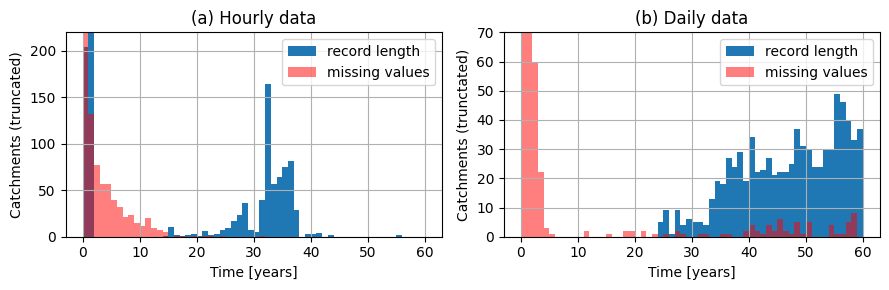

In [227]:
fig, axs = plt.subplots(1,2,figsize=(9,3))
truncate = True

## Daily
ax1 = axs[0]
bin_edges = np.linspace(0,60,61)
(df['ha']/(365.25*24)).hist(bins=bin_edges, ax=ax1, label='record length')
(df['hm']/(365.25*24)).hist(bins=bin_edges, ax=ax1, alpha=0.5, color='red', label='missing values')
ax1.legend();
ax1.set_title('(a) Hourly data')
ax1.set_xlabel('Time [years]')
ax1.set_ylabel('Catchments')

## Hourly
ax2 = axs[1]
bin_edges = np.linspace(0,60,61)
(df['da']/(365.25)).hist(bins=bin_edges, ax=ax2, label='record length')
(df['dm']/(365.25)).hist(bins=bin_edges, ax=ax2, alpha=0.5, color='red', label='missing values')
ax2.legend();
ax2.set_title('(b) Daily data')
ax2.set_xlabel('Time [years]')
ax2.set_ylabel('Catchments')

plt.tight_layout()
plt.savefig(image_path / 'streamflow_histograms.png', dpi=300, bbox_inches='tight')

# Truncate
if truncate:
    ax1.set_ylim([0,220])
    ax2.set_ylim([0,70])
    ax1.set_ylabel('Catchments (truncated)')
    ax2.set_ylabel('Catchments (trunctated)')
    plt.tight_layout()
    plt.savefig(image_path / 'streamflow_histograms_truncated.png', dpi=300, bbox_inches='tight')

In [223]:
np.histogram(df['ha']/(365.25*24), bins=bin_edges)

(array([204, 560,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   1,  11,   2,   1,   2,   3,   1,   6,   2,   3,   7,   9,
         17,  23,  36,   7,   5,  40, 164,  57,  64,  75,  82,  29,   0,
          3,   3,   4,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   2,   0,   0,   0,   0]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60.]))

In [224]:
np.histogram(df['hm']/(365.25*24), bins=bin_edges)

(array([913, 132,  77,  57,  57,  39,  32,  21,  23,  15,  12,  20,   9,
          7,   5,   0,   1,   1,   0,   1,   0,   1,   1,   0,   1,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60.]))

In [226]:
np.histogram(df['dm']/(365.25), bins=bin_edges)

(array([1156,  112,   60,   22,    3,    1,    0,    0,    0,    0,    0,
           2,    0,    0,    0,    1,    0,    0,    2,    2,    0,    2,
           0,    1,    0,    1,    0,    2,    1,    0,    0,    1,    1,
           0,    0,    1,    1,    0,    0,    2,    4,    2,    1,    4,
           2,    6,    2,    1,    5,    1,    5,    0,    0,    0,    4,
           1,    1,    5,    8,    0]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60.]))